# Check the Azure ML SDK Version¶


Let's start by importing the azureml-core package and checking the version of the SDK that is installed.

In [1]:
import azureml.core
print("Its working fine",azureml.core.VERSION)

Its working fine 1.2.0


# Connect to Your Workspace

All experiments and associated resources are managed within you Azure ML workspace. You can connect to an existing workspace, or create a new one using the Azure ML SDK.
you should store the workspace configuration in a JSON configuration file.
The code below uses the configuration file to connect to your workspace.

In [2]:
from azureml.core import Workspace
ws = Workspace.from_config()
print(ws.name,"loaded")

skillenza loaded


# Run an Experiment

In [4]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#creating an Azure ML Experiment in workspace
#name is the data or project you are working with
experiment = Experiment(workspace=ws,name ="diabetes-experiments")

#start logging data from the experiment
run = experiment.start_logging()
print("starting experiment",experiment.name)

starting experiment diabetes-experiments


In [5]:
#check working directory
!pwd

/mnt/batch/tasks/shared/LS_root/mounts/clusters/unilever/code/Users/iitrtandi


In [9]:
#load data 
data = pd.read_csv("kaggle_data/diabetes.csv")

In [11]:
#something you can do along with experiment in microsoft ml
#load and log output result
row_count=len(data)
run.log("number of observations",row_count)   #run is the logger instance 
print("Analysis {} of data".format(row_count))


Analysis 10000 of data


In [12]:
data.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


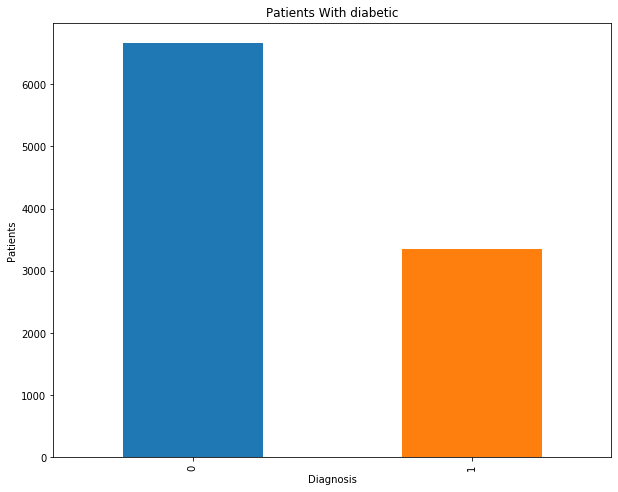

In [14]:
#plot the diabetic and non-diabetic patients and log the file
diabetic_yes = data["Diabetic"].value_counts()
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
diabetic_yes.plot.bar(ax=ax)
ax.set_title("Patients With diabetic")
ax.set_xlabel("Diagnosis")
ax.set_ylabel("Patients")
plt.show()
run.log_image(name = 'label distribution', plot = fig)

In [17]:
#log unique patients count
pregnancies = data.Pregnancies.unique()
run.log_list("pregnancy category",pregnancies)
print("list will be logged {}".format(pregnancies))

list will be logged [ 0  8  7  9  1  3  5  2  6 11  4 13 10 12 14]


See First we log count then image and now a list

In [18]:
#log summary statistics about patients 
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat = keys[index], value = values[index])
        
# Save a sample of the data and upload it to the experiment output
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name = 'outputs/sample.csv', path_or_stream = './sample.csv')

# Complete the run
run.complete()

# View Experiment Results

In [23]:
import json

#run details
details = run.get_details()
print(details)

{'runId': '00681343-2f98-45e3-be91-3b2efbad3774', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2020-03-26T12:33:08.131123Z', 'endTimeUtc': '2020-03-26T12:49:20.259609Z', 'properties': {'ContentSnapshotId': '36c3f0c7-ecfc-4f99-a615-0adba1090d23'}, 'inputDatasets': [], 'logFiles': {}}


In [25]:
#get loggeed metrics
metrics = run.get_metrics()
print(json.dumps(metrics,indent=2))

{
  "number of observations": [
    10000,
    10000
  ],
  "label distribution": "aml://artifactId/ExperimentRun/dcid.00681343-2f98-45e3-be91-3b2efbad3774/label distribution_1585226645.png",
  "pregnancy category": [
    0,
    8,
    7,
    9,
    1,
    3,
    5,
    2,
    6,
    11,
    4,
    13,
    10,
    12,
    14,
    0,
    8,
    7,
    9,
    1,
    3,
    5,
    2,
    6,
    11,
    4,
    13,
    10,
    12,
    14
  ],
  "PlasmaGlucose": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%",
      "max"
    ],
    "value": [
      10000.0,
      107.8502,
      31.920909360565563,
      44,
      84,
      105,
      129,
      192
    ]
  },
  "DiastolicBloodPressure": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%",
      "max"
    ],
    "value": [
      10000.0,
      71.2075,
      16.801478289640706,
      24,
      58,
      72,
      85,
      1

In [26]:
# Get output files
files = run.get_file_names()
print(json.dumps(files, indent=2))

[
  "label distribution_1585226645.png",
  "outputs/sample.csv"
]


In [27]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

# Run an Experiment Script

In the previous example, you ran an experiment inline in this notebook. A more flexible solution is to create a separate script for the experiment, and store it in a folder along with any other files it needs, and then use Azure ML to run the experiment based on the script in the folder.

First, let's create a folder for the experiment files, and copy the data into it:

In [28]:
import os, shutil

#create a folder for puppose
folder_name = "diabetes-experiment-files"
experiment_folder = "./"+folder_name
os.makedirs(folder_name,exist_ok=True)

In [30]:
# Copy the data file into the experiment folder
shutil.copy('Kaggle_data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

In [31]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
data = pd.read_csv('diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Count and log the label counts
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# Complete the run
run.complete()

Writing diabetes-experiment-files/diabetes_experiment.py


In [32]:
import os
import sys
from azureml.core import Experiment, RunConfiguration, ScriptRunConfig
from azureml.widgets import RunDetails

# create a new RunConfig object
experiment_run_config = RunConfiguration()

# Create a script config
src = ScriptRunConfig(source_directory=experiment_folder, 
                      script='diabetes_experiment.py',
                      run_config=experiment_run_config) 

# submit the experiment
experiment = Experiment(workspace = ws, name = 'diabetes-experiment')
run = experiment.submit(config=src)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'diabetes-experiment_1585227784_37bd5b0e',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2020-03-26T13:03:09.82494Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'ea4547d3-9e40-4380-8a9e-7ce59424d121'},
 'inputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'Experiment diabetes-experiment Environment',
   'version': 'Autosave_2020-03-26T11:10:08Z_439d4836',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2', {'pip': ['azureml-defaults']}],
     'name': 'azureml_da3e97fcb51801118b8e80207f3e

In [33]:
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 10000
Label:0 6656
Label:1 3344


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/17508_azureml.log
outputs/sample.csv


# View Experiment Run History

In [34]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['diabetes-experiment']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: diabetes-experiment_1585227784_37bd5b0e
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: diabetes-experiment_1585221008_19c1c17a
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: d03db223-31e8-4c23-8210-2f57ab36b4e0
- observations 10000
- label distribution aml://artifactId/ExperimentRun/dcid.d03db223-31e8-4c23-8210-2f57ab36b4e0/label distribution_1585220888.png
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44, 84, 105, 129, 192]}
- DiastolicBloodPressure {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24, 58, 72, 85, 117]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7, 15, 31, 41, 92]}
- SerumInsulin {'stat': ['count', 'mean', 'std', 'min